<a href="https://colab.research.google.com/github/hungtrieu07/VietnameseLicensePlateRecognition/blob/main/Nh%E1%BA%ADn_di%E1%BB%87n_bi%E1%BB%83n_s%E1%BB%91_xe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.models import Sequential
from keras.layers import AveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext, basename
import glob
import numpy as np

# Train model nhận diện chữ trên biển số

In [ ]:
!unzip /content/drive/MyDrive/BTLAI2/dataset_characters.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_characters/V/V_226.jpg  
  inflating: dataset_characters/V/V_227.jpg  
  inflating: dataset_characters/V/V_228.jpg  
  inflating: dataset_characters/V/V_229.jpg  
  inflating: dataset_characters/V/V_23.jpg  
  inflating: dataset_characters/V/V_230.jpg  
  inflating: dataset_characters/V/V_231.jpg  
  inflating: dataset_characters/V/V_232.jpg  
  inflating: dataset_characters/V/V_233.jpg  
  inflating: dataset_characters/V/V_234.jpg  
  inflating: dataset_characters/V/V_235.jpg  
  inflating: dataset_characters/V/V_236.jpg  
  inflating: dataset_characters/V/V_237.jpg  
  inflating: dataset_characters/V/V_238.jpg  
  inflating: dataset_characters/V/V_239.jpg  
  inflating: dataset_characters/V/V_24.jpg  
  inflating: dataset_characters/V/V_240.jpg  
  inflating: dataset_characters/V/V_241.jpg  
  inflating: dataset_characters/V/V_242.jpg  
  inflating: dataset_characters/V/V_243.jpg  
  inflating: dataset_characters

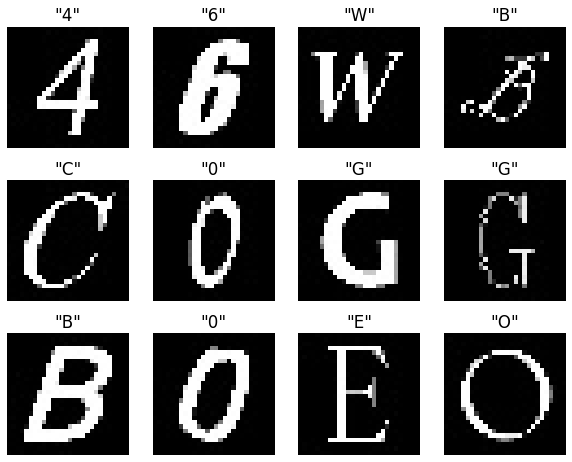

In [ ]:
dataset_paths = glob.glob("/content/dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)  

In [ ]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('/content/drive/MyDrive/BTLAI2/license_character_classes.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [ ]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [ ]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [ ]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [ ]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="/content/drive/MyDrive/BTLAI2/License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
529/529 [==============================] - ETA: 0s - loss: 1.4863 - accuracy: 0.6080
Epoch 1: saving model to /content/drive/MyDrive/BTLAI2/License_character_recognition.h5
529/529 [==============================] - 109s 176ms/step - loss: 1.4863 - accuracy: 0.6080 - val_loss: 1.4257 - val_accuracy: 0.6471
Epoch 2/30
529/529 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8893
Epoch 2: saving model to /content/drive/MyDrive/BTLAI2/License_character_recognition.h5
529/529 [==============================] - 89s 169ms/step - loss: 0.4149 - accuracy: 0.8893 - val_loss: 0.4036 - val_accuracy: 0.8910
Epoch 3/30
529/529 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9189
Epoch 3: saving model to /content/drive/MyDrive/BTLAI2/License_character_recognition.h5
529/529 [==============================] - 89s 169ms/step - loss: 0.3002 - accuracy: 0.9189 - val_loss: 0.2385 - val_accuracy: 0.9341
Epoch 4/30
529/529 [=========================

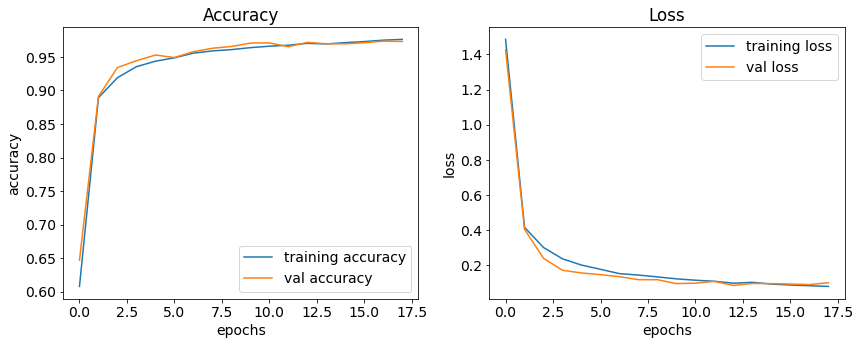

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [ ]:
# save model architecture as json file
model_json = model.to_json()
with open("/content/drive/MyDrive/BTLAI2/MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

# Data mới để test mô hình (nhưng k được fit như mô hình trên)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format

In [ ]:
!kaggle competitions download -c digit-recognizer

In [ ]:
!unzip train.csv.zip
!unzip az-handwritten-alphabets-in-csv-format.zip

In [ ]:
%mkdir dataset

In [ ]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import load_img
import tensorflow as tf
from sklearn import preprocessing, model_selection

In [ ]:
for i in range(10):
    os.mkdir('dataset/' + str(i))

with open("train.csv") as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size

for i in range(1,num_of_instances):
    try:
        img = lines[i].split(",")
        pixels = img[1:]

        pixels = np.array(pixels, 'float32')
        image = pixels.reshape(28, 28)

        path_file_name = 'dataset/' + str(img[0]) +"/" + str(i) + ".jpg"
        cv2.imwrite(path_file_name, image)

    except Exception as ex:
    	print(ex)

In [ ]:
for j in range(26):
    os.mkdir('dataset/' + chr(j+65))

with open("A_Z Handwritten Data.csv") as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size

for i in range(0, num_of_instances):
    try:
        img = lines[i].split(",")
        pixels = img[:-1]
        pixels = np.array(pixels, 'float32')
        image = pixels.reshape(28, 28)

        path_file_name = 'dataset/' + chr(int(img[0])+65) +"//" + str(i) + ".jpg"
        cv2.imwrite(path_file_name, image)

    except Exception as ex:
        print(ex)

In [ ]:
dataset_paths = glob.glob("dataset/**/*.jpg")

In [ ]:
cols=4
rows=4
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [ ]:
character_size = []
directory = 'dataset/'
list_folder = os.listdir(directory)
fig = plt.figure(figsize=(10,8))
for folder in list_folder:
  count = 0
  for file in os.listdir(directory + folder):
    count +=1
  character_size.append([folder, count])
character_size.sort()
for i in  character_size:
  plt.bar(i[0], i[1])
plt.show()


In [ ]:
character_size.sort(key = lambda x: x[1]) 
minimum_data = character_size[0][1]

In [ ]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  if(labels.count(label) == minimum_data):
    continue
  image=tf.keras.preprocessing.image.load_img(image_path,target_size=(80,80))
  image=tf.keras.preprocessing.image.img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

In [ ]:
lb = preprocessing.LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = tf.keras.utils.to_categorical(labels)

# save label file so we can use in another script
np.save('/content/drive/MyDrive/BTLAI2/license_character_classes_1.npy', lb.classes_)

In [ ]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = model_selection.train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [ ]:
# generate data augumentation method
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [ ]:
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=tf.keras.Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
    headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
    headModel = tf.keras.layers.Dropout(0.5)(headModel)
    headModel = tf.keras.layers.Dense(output_shape, activation="softmax")(headModel)
    
    model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
            
        # compile model
        optimizer = tf.keras.optimizers.Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [ ]:
INIT_LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 64

In [ ]:
model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

In [ ]:
model.summary()

In [ ]:
my_checkpointer = [
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/BTLAI2/License_character_recognition_1.h5", verbose=1, save_weights_only=True)
                ]

In [ ]:
result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Phát hiện biển số

In [ ]:
import cv2
import numpy as np


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor


In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
wpod_net_path = "/content/drive/MyDrive/BTLAI2/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:
def preprocess_image(image,resize=False):
    # img = cv2.imread(image_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, wpod_net, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

def plate_image(image_path, wpod_net):
  LpImg, cor = get_plate(image_path, wpod_net)
  plate_img = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
  return plate_img

In [ ]:
def binary_image(image):
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 80, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    
    return thre_mor

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

def cut_image_to_2_images(image):
  h, w = image.shape
  bot = int(h*0.55)
  top = int(h*0.45)
  image_top = image[0:bot, 0:w]
  image_bottom = image[top:h, 0:w]
  return image_top, image_bottom

def get_characters_from_image(image):

	#get contour
	cont  = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

	#characters
	crop_characters = []

	digit_w, digit_h = 30, 60

	for c in sort_contours(cont):
	    (x, y, w, h) = cv2.boundingRect(c)
	    ratio = h/w
	    if 1<=ratio<=5: # Only select contour with defined ratio
	        if h/image.shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate

	            # Sperate number and gibe prediction
	            curr_num = image[y:y+h,x:x+w]
	            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
	            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	            crop_characters.append(curr_num)

	return crop_characters

def get_characters(image):
	image_top, image_bottom = cut_image_to_2_images(image)
	charater_top = get_characters_from_image(image_top)
	charater_bot = get_characters_from_image(image_bottom)

	return charater_top, charater_bot

In [ ]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

In [ ]:
def string_LP(list_image, model, labels):
  final_string = ''
  for i in list_image:
    title = np.array2string(predict_from_model(i,model,labels))
    final_string+=title.strip("'[]")
  return final_string

In [ ]:
random_image = random.choice(os.listdir("/content/drive/MyDrive/BTLAI2/GreenParking"))
random_image_path = '/content/drive/MyDrive/BTLAI2/GreenParking' + '/' + random_image
print(random_image_path)


/content/drive/MyDrive/BTLAI2/GreenParking/0331_05809_b.jpg


In [ ]:
image = cv2.imread(random_image_path)
wpod_net_model = load_model("/content/drive/MyDrive/BTLAI2/wpod-net_update1.json")
plate_image = plate_image(image, wpod_net_model)
binary_plate_image = binary_image(plate_image)
charater_top, charater_bot = get_characters(binary_plate_image)
json_file = open('/content/drive/MyDrive/BTLAI2/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/BTLAI2/License_character_recognition.h5")
labels = LabelEncoder()
labels.classes_ = np.load('/content/drive/MyDrive/BTLAI2/license_character_classes.npy')
json_file.close()

Loading model successfully...


Biển số nhận dạng được: 
59T1
22189


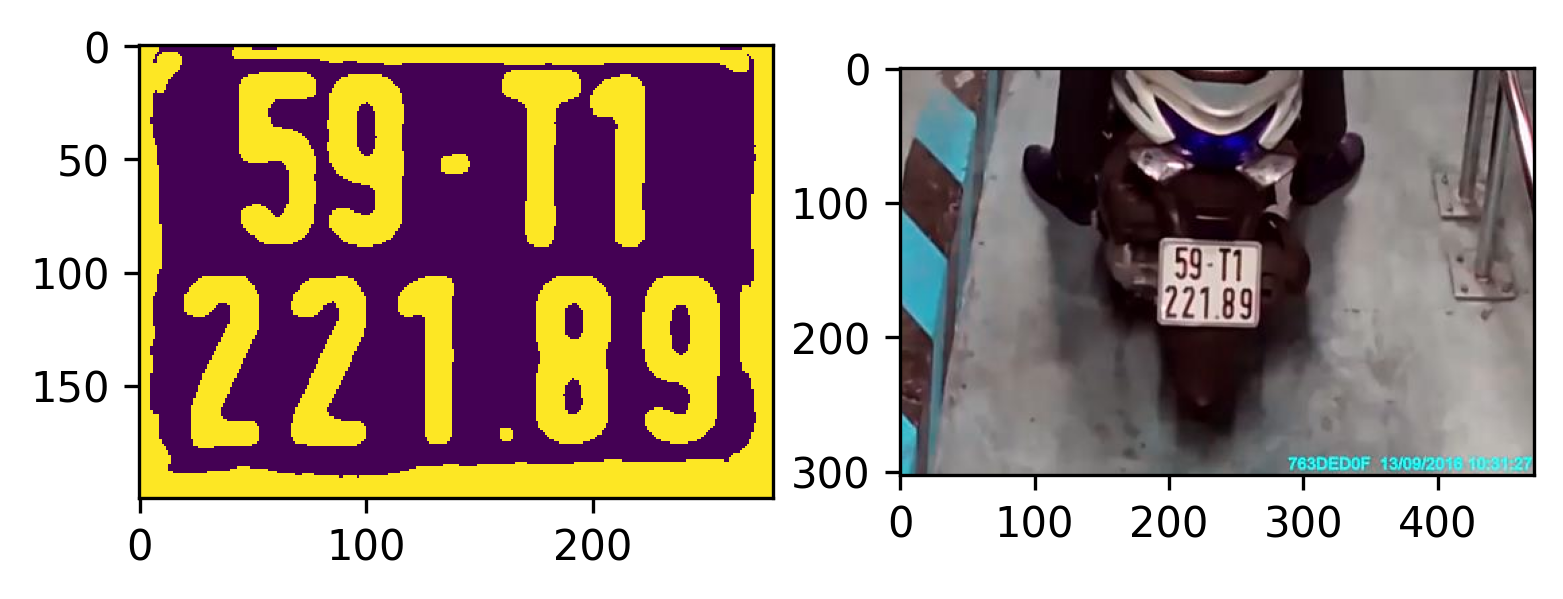

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(binary_plate_image, interpolation='nearest')
axarr[1].imshow(image)

# plt.imshow(binary_plate_image, interpolation='nearest')
# plt.axis('off')

# plt.imshow(image, cmap='gray')
# plt.axis('off')

print("Biển số nhận dạng được: ")
print(string_LP(charater_top, model, labels))
print(string_LP(charater_bot, model, labels))

In [ ]:
!git config --global user.email "hungtrieu0701@gmail.com"

In [ ]:
!git config --global user.name "hungtrieu07"